In [1]:
import sys

#key python packages
import pandas as pd
import numpy as np
import scipy
import math

#data visualization
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import colors
import seaborn as sns
%matplotlib inline

# statistics
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# pySEAS packages
sys.path.append('/home/feldheimlab/Documents/pySEAS/')#only use if you clone repository, if pip installed no need
from seas.hdf5manager import hdf5manager as h5
from seas.waveletAnalysis import waveletAnalysis as wave
from seas.ica import *

# plt.style.use('publication')
dataset_path = '/media/feldheimlab/DF Transfer/misc - IS THIS YOURS/p21_20m/'
plt.rcParams['font.size'] = 8

save = True
save_dir = '/home/feldheimlab/Desktop/figures/'


# Montage

In [3]:
file = '190508_07-08_ica.hdf5'
h = h5(dataset_path + file)
print(h.print())

flipped = h.load('flipped')
tcourse = h.load('timecourses')

#flipped the inverted timeseries
tcourse = (np.multiply(tcourse.T, flipped)).T

#load mask
roimask = h.load('roimask')

#load eig_vec
eig_vec = h.load('eig_vec')
thresh = h.load('thresholds')


Opening File to read...
/media/feldheimlab/DF Transfer/misc - IS THIS YOURS/p21_20m/190508_07-08_ica.hdf5 has the following keys:
	- ROI_timecourses
	- artifact_components
	- artifact_mask
	- artifact_timecourse
	- domain_ROIs
	- eig_mix
	- eig_val
	- eig_vec
	- expmeta
	- filter
	- flipped
	- lag1
	- lag1_full
	- mean
	- mean_filter_meta
	- mean_filtered
	- noise_components
	- region_assignment
	- roimask
	- svd_eigval
	- thresholds
	- timecourses
/media/feldheimlab/DF Transfer/misc - IS THIS YOURS/p21_20m/190508_07-08_ica.hdf5 has the following attributes:
	- PCAtype
	- cutoff
	- increased_cutoff
	- n_components
	- region_labels
	- shape
	- svd_cutoff
	- svd_multiplier
	- time
Closing file...

None


24
143
163
3
174
67


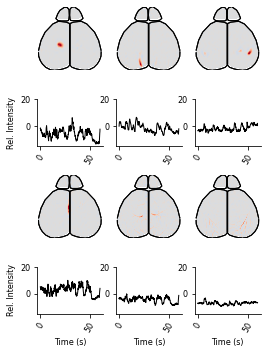

In [4]:
mean = h.load('mean_filtered')

pc_id =[24,143,163,3,174,67]

#TC show off
start = 1800
end = 2400
icmin = -0.010 
icmax = 0.010

fig = plt.figure(figsize=(4,6))

for j, ind in enumerate(pc_id):
    print(ind)
    if j>2:
        axs0 = plt.subplot2grid((6,3),(3,j%3),rowspan=2)
        axs1 = plt.subplot2grid((6,3),(5,j%3),rowspan=1)
    else:
        axs0 = plt.subplot2grid((6,3),(0,j),rowspan=2)
        axs1 = plt.subplot2grid((6,3),(2,j),rowspan=1)
        
    component = rebuild_eigenbrain(eig_vec, ind, roimask=roimask, eigb_shape=None, maskind=None)
    
    threshold = thresh[ind]
    tc = tcourse[ind]#
    component = np.rot90(component*flipped[ind], 2)
    roi = np.rot90(roimask, 2)
    X,Y=np.meshgrid(np.arange(0,roi.shape[1],1), np.arange(0,roi.shape[0],1))

    time = np.arange(tc[start:end].shape[0])/10
    axs0.imshow(component, clim=(icmin,icmax), norm=MidpointNormalize(midpoint=0,vmin=icmin, vmax=icmax),cmap= 'coolwarm')
    axs0.contour(X, Y, roi, colors='k', levels=1, linewidths=1)
    axs0.set_xlim([-30,roi.shape[1]+30])
    axs0.set_xlim([-30,roi.shape[0]+30])
    axs0.axis('off')
    
    if j == 0:
        axs1.plot(time, tc[start:end], c='k', linewidth=1)
        lims = axs1.get_ylim()
    else:
        axs1.plot(time, tc[start:end], c='k', linewidth=1)
        axs1.set_ylim(lims)

    
    
    axs1.set_ylim([-15,20])
    axs1.spines['right'].set_visible(False)
    axs1.spines['top'].set_visible(False)
    axs1.yaxis.set_ticks_position('left')
    axs1.xaxis.set_ticks_position('bottom')
    axs1.set_ylim()
    axs1.tick_params(axis = 'x', labelrotation=60)

    if j == 0 or j == 3:
        axs1.set_ylabel('Rel. Intensity')
    if j > 2:
        axs1.set_xlabel('Time (s)')

if save:
    plt.savefig(save_dir+'component_examples.svg', dpi=600)
plt.show()




61
156


/tmp/ipykernel_412509/772177723.py:33: UserWarning: No contour levels were found within the data range.
  axs0.contour(X, Y, roi, colors='k', levels=[0,1], linewidths=1)
/tmp/ipykernel_412509/772177723.py:33: UserWarning: No contour levels were found within the data range.
  axs0.contour(X, Y, roi, colors='k', levels=[0,1], linewidths=1)
/tmp/ipykernel_412509/772177723.py:33: UserWarning: No contour levels were found within the data range.
  axs0.contour(X, Y, roi, colors='k', levels=[0,1], linewidths=1)


316
35


/tmp/ipykernel_412509/772177723.py:33: UserWarning: No contour levels were found within the data range.
  axs0.contour(X, Y, roi, colors='k', levels=[0,1], linewidths=1)
/tmp/ipykernel_412509/772177723.py:33: UserWarning: No contour levels were found within the data range.
  axs0.contour(X, Y, roi, colors='k', levels=[0,1], linewidths=1)


174
362


/tmp/ipykernel_412509/772177723.py:33: UserWarning: No contour levels were found within the data range.
  axs0.contour(X, Y, roi, colors='k', levels=[0,1], linewidths=1)


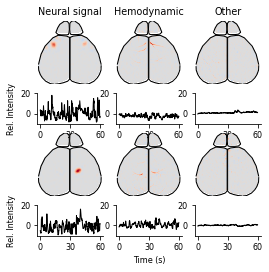

In [5]:
pc_id = [61, 156, 316, 35, 174, 362] # '190514_07-08_ica.hdf5' 
#signal-blood, signal-Neural, movement-artifact, optical-artifact, noise;
pc_label=['Neural signal', 'Hemodynamic', 'Other']

#TC show off
start = 4500
end = 5100
icmin = -0.010 
icmax = 0.010

fig = plt.figure(figsize=(4,4))


for j, ind in enumerate(pc_id):
    print(ind)
    if j>2:
        axs0 = plt.subplot2grid((6,3),(3,j%3),rowspan=2)
        axs1 = plt.subplot2grid((6,3),(5,j%3),rowspan=1)
    else:
        axs0 = plt.subplot2grid((6,3),(0,j),rowspan=2)
        axs1 = plt.subplot2grid((6,3),(2,j),rowspan=1)
        
    component = rebuild_eigenbrain(eig_vec, ind, roimask=roimask, eigb_shape=None, maskind=None)
    
    threshold = thresh[ind]
    tc = tcourse[ind]#
    component = np.rot90(component*flipped[ind], 2)
    roi = np.rot90(roimask, 2)
    X,Y = np.meshgrid(np.arange(0,roi.shape[1],1), np.arange(0,roi.shape[0],1))
    time = np.arange(tc[start:end].shape[0])/10
    im = axs0.imshow(component, clim=(icmin,icmax), norm=MidpointNormalize(midpoint=0,vmin=icmin, vmax=icmax),cmap= 'coolwarm')
    
    axs0.contour(X, Y, roi, colors='k', levels=[0,1], linewidths=1)
    axs0.set_xlim([-30,roi.shape[1]+30])
    axs0.set_xlim([-30,roi.shape[0]+30])
    axs0.axis('off')

    axs1.plot(time, tc[start:end], c='k', linewidth = 1)
    axs1.set_ylim([-10,20])
    axs1.spines['right'].set_visible(False)
    axs1.spines['top'].set_visible(False)
    axs1.yaxis.set_ticks_position('left')
    axs1.xaxis.set_ticks_position('bottom')
    axs1.set_xticks(np.arange(0,90,30))
    if j == 0 or j == 3:
        axs1.set_ylabel('Rel. Intensity')
    if j == 4:
        axs1.set_xlabel('Time (s)')
    if j < 3:
        axs0.set_title(pc_label[j])
#     if j == 2:
#         divider = make_axes_locatable(axs0)
#         cax = divider.append_axes('right', size='5%', pad=0.05)
#         cbar2 = fig.colorbar(im, cax=cax, orientation='vertical')
if save:
    plt.savefig(save_dir+'eigenvec_types.svg', dpi=600)
plt.show()



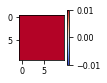

In [6]:
fig = plt.figure(figsize=(1,1))

icmin = -0.010 
icmax = 0.010
cax = plt.imshow(np.ones((10,10)), clim=(icmin,icmax), norm=MidpointNormalize(midpoint=0,vmin=icmin, vmax=icmax),cmap= 'coolwarm')
cbar = plt.colorbar(cax, ticks=[-0.01, 0, 0.01])
if save:
    fig.savefig(save_dir+'colorbar_eigenvector.svg', dpi=600)
plt.show()

# Quantities

In [7]:
# create novel and testing datasets for ML

n_components = []
n_signal = []
n_artifact = []

novel = pd.read_csv('./data/novel_dataset.tsv', sep='\t', index_col='exp_ic')
training = pd.read_csv('./data/training_dataset.tsv', sep='\t', index_col='exp_ic')
novel['train'] = 0
training['train'] = 1
print(len(np.unique(training)), len(training))
print(len(np.unique(novel)), len(novel))

data = pd.concat([novel, training])
data = data.sort_index()
data = data.fillna(0)
print(data.head())
j=-1
current = 'Nope'
for i, ind in enumerate(data.index):
    if ind[:12]==current:
        data.loc[ind,'anml']=j
    else:
        j+=1
        data.loc[ind,'anml']=j
        current=ind[:12]
print(len(data))

# animaltrain = [0.0, 3.0, 4.0, 5.0, 8.0, 9.0, 10.0]
# animalnovel = [1.0, 2.0, 6.0, 7.0, 11.0]


# training = data[data['anml'].isin(animaltrain)].copy()
# novel = data[data['anml'].isin(animalnovel)].copy()

# novel.to_csv()
# training.to_csv(expdir + 'training_dataset.tsv', sep='\t')

55536 2190
41488 1661
                   age  freq.avgsnr  freq.integrate  freq.maxsnr  \
exp_ic                                                             
190408_03-04-0000   22     1.193897        0.006304     1.327806   
190408_03-04-0001   22     1.422100        0.120683     1.620314   
190408_03-04-0002   22     1.296523        0.107689     1.513039   
190408_03-04-0003   22     1.172093        0.179745     1.306229   
190408_03-04-0004   22     2.093038        0.589769     3.606708   

                   freq.maxsnr.freq  freq.range.high  freq.range.low  \
exp_ic                                                                 
190408_03-04-0000          4.204482         4.585020        2.973018   
190408_03-04-0001          4.585020         0.005325        0.004883   
190408_03-04-0002          4.585020         0.005325        0.004883   
190408_03-04-0003          2.973018         0.963882        0.371627   
190408_03-04-0004          3.242099         0.007530        0.004883 

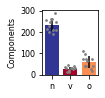

In [8]:
prop = pd.DataFrame()

col = plt.cm.get_cmap('RdYlBu',5)

for a in np.unique(data['anml']):
    single = data[data['anml']==a]
    exp = single.index[0]
    prop.loc[exp[:12], 'n_components'] = len(single)
    prop.loc[exp[:12], 'n_signal'] = np.sum(single['signal'])
    prop.loc[exp[:12], 'n_artifact'] = np.sum(single['artifact'])
    prop.loc[exp[:12], 'n_hemo'] = np.sum(single['hemodynamic'])
    prop.loc[exp[:12], 'n_move'] = np.sum(single['movement'])
    prop.loc[exp[:12], 'anml'] = a
    prop.loc[exp[:12], 'train'] = single.loc[exp, 'train']

prop['perc_signal'] = prop['n_signal']/prop['n_components']
prop['perc_artifact'] = prop['n_artifact']/prop['n_components']
prop['perc_hemo'] = prop['n_hemo']/prop['n_components']
prop['perc_move'] = prop['n_move']/prop['n_components']


plt.figure(figsize = (1.,1.2))

b1 = plt.bar(np.arange(3)-.25, prop.mean()[[1,3,4]], yerr=prop.std()[[1,3,4]], 
             alpha = 1, width=0.75, color = [col(5), col(0), col(1)], zorder = 0)


plt.scatter(np.zeros(len(prop['n_signal']))-.6+np.random.random(len(prop['n_signal']))*.6, 
            prop['n_signal'], c='grey',s=3)
plt.scatter(np.ones(len(prop['n_hemo']))-.6+np.random.random(len(prop['n_hemo']))*.6, 
            prop['n_hemo'], c='grey',s=3)
plt.scatter(np.ones(len(prop['n_move']))*2-.6+np.random.random(len(prop['n_move']))*.6, 
            prop['n_move'], c='grey',s=3)

plt.xticks([-.25,.75,1.75 ], ['n', 'v', 'o'])
plt.yticks(np.arange(0,400,100), np.arange(0,400,100))

plt.ylabel('Components')
if save:
    plt.savefig(save_dir+'classification.svg', dpi=600)
plt.show()


# control data integration

./data/190613_01-02_600components_ica_metrics.tsv
190408_03-04
190408_07-08
190423_03-04
190423_07-08
190506_03-04
190506_07-08
190508_03-04
190508_07-08
190603_01-02
200108_01-02
200109_01-02
200110_01-02
171211_01-02_600components_ica.hdf5
191111_01-02_600components_ica.hdf5
191112_01-02_600components_ica.hdf5
190613_01-02_600components_ica.hdf5
190613_03-04_600components_ica.hdf5
190329_02-03_600components_ica.hdf5
190625_01-02_600components_ica.hdf5
190904_01-02_600components_ica.hdf5
190625_03-04_600components_ica.hdf5
62.0 54.333333333333336 39.333333333333336
[234.25, 62.0, 54.333333333333336, 39.333333333333336]


/home/feldheimlab/.local/lib/python3.8/site-packages/seaborn/categorical.py:3544: UserWarning: 33.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/feldheimlab/.local/lib/python3.8/site-packages/seaborn/categorical.py:3544: UserWarning: 33.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/feldheimlab/.local/lib/python3.8/site-packages/seaborn/categorical.py:3544: UserWarning: 16.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/feldheimlab/.local/lib/python3.8/site-packages/seaborn/categorical.py:3544: UserWarning: 41.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


signal            186
hemodynamic      72.0
movement        226.0
control        mGmGmG
dtype: object
signal            163
hemodynamic      78.0
movement        201.0
control        aGaGaG
dtype: object
signal            118
hemodynamic      50.0
movement         61.0
control        WTWTWT
dtype: object


/home/feldheimlab/.local/lib/python3.8/site-packages/seaborn/categorical.py:3544: UserWarning: 66.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/feldheimlab/.local/lib/python3.8/site-packages/seaborn/categorical.py:3544: UserWarning: 33.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


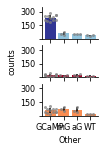

In [9]:
wd = './data/'


aGFP_list = ['190613_01-02_600components_ica.hdf5',
             '190613_03-04_600components_ica.hdf5',
             '190329_02-03_600components_ica.hdf5'
            ]
mGFP_list =['171211_01-02_600components_ica.hdf5',
            '191111_01-02_600components_ica.hdf5',
            '191112_01-02_600components_ica.hdf5'
           ]
WT_list = ['190625_01-02_600components_ica.hdf5',
           '190904_01-02_600components_ica.hdf5',
           '190625_03-04_600components_ica.hdf5'
           ]

print(wd + aGFP_list[0][:-5]+'_metrics.tsv')

summary = pd.DataFrame(columns=['signal','hemodynamic','movement','control'])

for index in prop.index:
    print(index)
    summary.loc[index, 'signal'] = prop.loc[index,'n_signal']
    summary.loc[index, 'hemodynamic'] = prop.loc[index,'n_hemo']
    summary.loc[index, 'movement'] = prop.loc[index,'n_move']
    summary.loc[index, 'control'] = 'GCaMP'


for i, file in enumerate(mGFP_list):
    print(file)
    subset = pd.read_csv(wd + file[:-5]+'_metrics.tsv', sep = "\t", index_col='exp_ic')
    subset['control'] = 'mG'
    summary.loc[file[:12],'control'] = 'mG'
    summary.loc[file[:12],'signal'] = np.sum(subset['signal'])
    summary.loc[file[:12],'hemodynamic'] = np.sum(subset['hemodynamic'])
    summary.loc[file[:12],'movement'] = np.sum(subset['movement'])
        
for file in aGFP_list:
    print(file)
    subset = pd.read_csv(wd + file[:-5]+'_metrics.tsv', sep = "\t", index_col='exp_ic')
    subset['control'] = 'aG'
    summary.loc[file[:12],'control'] = 'aG'
    summary.loc[file[:12],'signal'] = np.sum(subset['signal'])
    summary.loc[file[:12],'hemodynamic'] = np.sum(subset['hemodynamic'])
    summary.loc[file[:12],'movement'] = np.sum(subset['movement'])

for file in WT_list:
    print(file)
    subset = pd.read_csv(wd + file[:-5]+'_metrics.tsv', sep = "\t", index_col='exp_ic')
    subset['control'] = 'WT'
    summary.loc[file[:12],'control'] = 'WT'
    summary.loc[file[:12],'signal'] = np.sum(subset['signal'])
    summary.loc[file[:12],'hemodynamic'] = np.sum(subset['hemodynamic'])
    summary.loc[file[:12],'movement'] = np.sum(subset['movement'])

print(summary[summary['control']=='mG']['signal'].mean(),
      summary[summary['control']=='aG']['signal'].mean(),
      summary[summary['control']=='WT']['signal'].mean())


fig, axs = plt.subplots(3,1, figsize = (1,2))

sns.swarmplot(x='control', y='signal', data=summary, ax=axs[0], color = 'grey', alpha = 0.75, s=3)
mean = [summary[summary['control']=='GCaMP']['signal'].mean(),
        summary[summary['control']=='mG']['signal'].mean(),
        summary[summary['control']=='aG']['signal'].mean(),
        summary[summary['control']=='WT']['signal'].mean()]
stdev = [summary[summary['control']=='GCaMP']['signal'].std(),
         summary[summary['control']=='mG']['signal'].std(),
         summary[summary['control']=='aG']['signal'].std(),
         summary[summary['control']=='WT']['signal'].std()]
b1 = axs[0].bar(range(4), mean, yerr=stdev, zorder=0, color = [col(4), col(3), col(3), col(3)])

print(mean)

sns.swarmplot(x='control', y='hemodynamic', data=summary, ax=axs[1], color = 'grey', alpha = 0.75, s=3)
mean = [summary[summary['control']=='GCaMP']['hemodynamic'].mean(),
        summary[summary['control']=='mG']['hemodynamic'].mean(),
        summary[summary['control']=='aG']['hemodynamic'].mean(),
        summary[summary['control']=='WT']['hemodynamic'].mean()]
stdev = [summary[summary['control']=='GCaMP']['hemodynamic'].std(),
         summary[summary['control']=='mG']['hemodynamic'].std(),
         summary[summary['control']=='aG']['hemodynamic'].std(),
         summary[summary['control']=='WT']['hemodynamic'].std()]
axs[1].bar(range(4), mean, yerr=stdev, zorder=0, color = col(0))

sns.swarmplot(x='control', y='movement', data=summary, ax=axs[2], color = 'grey', alpha = 0.75, s=3)
mean = [summary[summary['control']=='GCaMP']['movement'].mean(),
        summary[summary['control']=='mG']['movement'].mean(),
        summary[summary['control']=='aG']['movement'].mean(),
        summary[summary['control']=='WT']['movement'].mean()]
stdev = [summary[summary['control']=='GCaMP']['movement'].std(),
         summary[summary['control']=='mG']['movement'].std(),
         summary[summary['control']=='aG']['movement'].std(),
         summary[summary['control']=='WT']['movement'].std()]
axs[2].bar(range(4), mean, yerr=stdev, zorder=0, color = col(1))

print(summary[summary['control']=='mG'].sum())
print(summary[summary['control']=='aG'].sum())
print(summary[summary['control']=='WT'].sum())

axs[0].set_title('')
axs[0].set_ylabel('')
axs[0].spines['right'].set_visible(False)
axs[0].spines['top'].set_visible(False)
axs[0].set_ylim([0,350])
axs[0].set_xlabel('Signal')
axs[0].set_yticks([0,150,300])
axs[0].set_yticklabels(['',150,300])
axs[0].set_xticklabels([])

axs[1].spines['right'].set_visible(False)
axs[1].spines['top'].set_visible(False)
axs[1].set_title('')
axs[1].set_ylabel('')
axs[1].set_ylim([0,350])
axs[1].set_xlabel('Vascular')
axs[1].set_ylabel('counts')
axs[1].set_xticklabels([])
axs[1].set_yticks([0,150,300])
axs[1].set_yticklabels(['',150,300])

axs[2].set_yticks([])
axs[2].set_yticklabels([])
axs[2].spines['right'].set_visible(False)
axs[2].spines['top'].set_visible(False)
axs[2].set_title('')
axs[2].set_ylabel('')
axs[2].set_ylim([0,350])
axs[2].set_xlabel('Other')
axs[2].set_yticks([0,150,300])
axs[2].set_yticklabels(['',150,300])

if save:
    plt.savefig(save_dir+'classification_wcontrols.svg', dpi=600)
plt.show()


In [10]:
summary2 = summary.drop('control', axis=1)
summary2 = summary2.join(pd.get_dummies(summary['control']))
print(summary)

             signal hemodynamic movement control
190408_03-04  209.0        31.0     26.0   GCaMP
190408_07-08  230.0        28.0     41.0   GCaMP
190423_03-04  210.0        32.0     72.0   GCaMP
190423_07-08  247.0        45.0     43.0   GCaMP
190506_03-04  245.0        35.0     73.0   GCaMP
190506_07-08  256.0        39.0     74.0   GCaMP
190508_03-04  259.0        32.0     42.0   GCaMP
190508_07-08  290.0        31.0     65.0   GCaMP
190603_01-02  262.0        22.0     96.0   GCaMP
200108_01-02  199.0        11.0     40.0   GCaMP
200109_01-02  191.0        17.0     19.0   GCaMP
200110_01-02  213.0        15.0    109.0   GCaMP
171211_01-02     47        23.0     99.0      mG
191111_01-02     58        21.0     56.0      mG
191112_01-02     81        28.0     71.0      mG
190613_01-02     50        27.0     47.0      aG
190613_03-04     57        18.0     57.0      aG
190329_02-03     56        33.0     97.0      aG
190625_01-02     37        21.0     20.0      WT
190904_01-02     41 

In [11]:
summary['signal'] = summary['signal'].astype('int')
summary['hemodynamic'] = summary['hemodynamic'].astype('int')
summary['movement'] = summary['movement'].astype('int')

print('Signal ANOVA')
model = ols('signal ~ C(control)', summary).fit()
print(sm.stats.anova_lm(model, typ=2))
print(pairwise_tukeyhsd(summary['signal'], summary['control']))
print('\nHemodynamic ANOVA')
model = ols('hemodynamic ~ C(control)', summary).fit()
print(sm.stats.anova_lm(model, typ=2))

print('\nMovement ANOVA')
model = ols('movement ~ C(control)', summary).fit()
print(sm.stats.anova_lm(model, typ=2))
print(pairwise_tukeyhsd(summary['movement'], summary['control']))


Signal ANOVA
                   sum_sq    df          F        PR(>F)
C(control)  171826.226190   3.0  91.086988  1.119509e-10
Residual     10689.583333  17.0        NaN           NaN
   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1 group2  meandiff p-adj    lower     upper   reject
---------------------------------------------------------
 GCaMP     WT -194.9167    0.0 -240.9275 -148.9059   True
 GCaMP     aG -179.9167    0.0 -225.9275 -133.9059   True
 GCaMP     mG   -172.25    0.0 -218.2608 -126.2392   True
    WT     aG      15.0 0.8826  -43.1996   73.1996  False
    WT     mG   22.6667 0.6902  -35.5329   80.8662  False
    aG     mG    7.6667 0.9815  -50.5329   65.8662  False
---------------------------------------------------------

Hemodynamic ANOVA
                 sum_sq    df         F    PR(>F)
C(control)   326.619048   3.0  1.389173  0.280146
Residual    1332.333333  17.0       NaN       NaN

Movement ANOVA
                  sum_sq    df         F  PR(>F)
C(

In [12]:
print('Signal ANOVA')
model = ols('signal ~ C(control)', summary).fit()
print(sm.stats.anova_lm(model, typ=2))
print(pairwise_tukeyhsd(summary['signal'], summary['control']))
model.t_test_pairwise('C(control)').result_frame

Signal ANOVA
                   sum_sq    df          F        PR(>F)
C(control)  171826.226190   3.0  91.086988  1.119509e-10
Residual     10689.583333  17.0        NaN           NaN
   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1 group2  meandiff p-adj    lower     upper   reject
---------------------------------------------------------
 GCaMP     WT -194.9167    0.0 -240.9275 -148.9059   True
 GCaMP     aG -179.9167    0.0 -225.9275 -133.9059   True
 GCaMP     mG   -172.25    0.0 -218.2608 -126.2392   True
    WT     aG      15.0 0.8826  -43.1996   73.1996  False
    WT     mG   22.6667 0.6902  -35.5329   80.8662  False
    aG     mG    7.6667 0.9815  -50.5329   65.8662  False
---------------------------------------------------------


,coef,std err,t,P>|t|,Conf. Int. Low,Conf. Int. Upp.,pvalue-hs,reject-hs
WT-GCaMP,-194.916667,16.186401,-12.042001,9.538402e-10,-229.066989,-160.766345,5.723041e-09,True
aG-GCaMP,-179.916667,16.186401,-11.115297,3.217277e-09,-214.066989,-145.766345,1.608638e-08,True
mG-GCaMP,-172.250000,16.186401,-10.641649,6.175700e-09,-206.400322,-138.099678,2.470280e-08,True
aG-WT,15.000000,20.474358,0.732624,4.737692e-01,-28.197120,58.197120,7.230811e-01,False
mG-WT,22.666667,20.474358,1.107076,2.836807e-01,-20.530453,65.863787,6.324470e-01,False
mG-aG,7.666667,20.474358,0.374452,7.126979e-01,-35.530453,50.863787,7.230811e-01,False
